In [1]:
%matplotlib notebook
%matplotlib inline

# Dependencies 
import pandas as pd
import requests
import json
import time
import matplotlib.pyplot as plt

#note - 5000 call limit per day for anonymous users on https://linc.osbm.nc.gov

In [2]:
#Create a basic data frame which has all countie and identifies high growth from NC_County_Growth.pynb

high_growth = 'data_import/cnty_growth.csv'
df1 = pd.read_csv(high_growth, usecols=[0,8])
df1['CO_NAME'] = df1['CO_NAME'].str.title() #The NC link API requries titlecase on the county parameter
df1.rename(columns ={'CO_NAME':'County'}, inplace = True)

#preview
df1.head(10)

,County,High_Growth
0,Brunswick,True
1,Pender,True
2,Johnston,True
3,Cabarrus,True
4,Chatham,True
5,Wake,True
6,Mecklenburg,True
7,Currituck,True
8,Union,True
9,New Hanover,True


In [3]:
#create a list of cnty crime data dictionaries/json  using high growth county dataframe
 #create empty list
ci = []
 #loop to append json data to list
    
years = ['2012','2013','2014','2015','2016', '2017'] #API Endpoint does not yet have 2018 crime index
url = 'https://linc.osbm.nc.gov/api/records/1.0/search/?'
dataset = 'law-enforcement-courts-and-correction-linc'

for y in years:
    for index, row in df1.iterrows():
        county = row['County']
        year = y
        qurl = f'{url}dataset={dataset}&refine.area_name={county}+County&refine.year={year}&refine.variable=Violent+Crimes+Reported'
        
        #build a response and json Object
        response = requests.get(qurl)
        response_json = response.json()
               
        try:
            #append the json slice to the list
            ci.append(response_json['records'][0]['fields'])
            print(f'{county} for {year} fetched')
            
        except:
            print(f'Error fetching crime index for {county} in {year}')
        
        time.sleep(response.elapsed.total_seconds())




Brunswick for 2012 fetched
Pender for 2012 fetched
Johnston for 2012 fetched
Cabarrus for 2012 fetched
Chatham for 2012 fetched
Wake for 2012 fetched
Mecklenburg for 2012 fetched
Currituck for 2012 fetched
Union for 2012 fetched
New Hanover for 2012 fetched
Durham for 2012 fetched
Franklin for 2012 fetched
Brunswick for 2013 fetched
Pender for 2013 fetched
Johnston for 2013 fetched
Cabarrus for 2013 fetched
Chatham for 2013 fetched
Wake for 2013 fetched
Mecklenburg for 2013 fetched
Currituck for 2013 fetched
Union for 2013 fetched
New Hanover for 2013 fetched
Durham for 2013 fetched
Franklin for 2013 fetched
Brunswick for 2014 fetched
Pender for 2014 fetched
Johnston for 2014 fetched
Cabarrus for 2014 fetched
Chatham for 2014 fetched
Wake for 2014 fetched
Mecklenburg for 2014 fetched
Currituck for 2014 fetched
Union for 2014 fetched
New Hanover for 2014 fetched
Durham for 2014 fetched
Franklin for 2014 fetched
Brunswick for 2015 fetched
Pender for 2015 fetched
Johnston for 2015 fetched

In [15]:
#Convert List to DF and preview
ci_yr = pd.DataFrame(ci)
ci_yr.head(20)

,variable,area_name,type,value,year
0,Violent Crimes Reported,Brunswick County,County,169,2012
1,Violent Crimes Reported,Pender County,County,126,2012
2,Violent Crimes Reported,Johnston County,County,319,2012
3,Violent Crimes Reported,Cabarrus County,County,241,2012
4,Violent Crimes Reported,Chatham County,County,103,2012
5,Violent Crimes Reported,Wake County,County,2420,2012
6,Violent Crimes Reported,Mecklenburg County,County,5519,2012
7,Violent Crimes Reported,Currituck County,County,37,2012
8,Violent Crimes Reported,Union County,County,503,2012
9,Violent Crimes Reported,New Hanover County,County,836,2012


In [4]:
#Convert List to new df
ci_yr = pd.DataFrame(ci)

# Clean up the dataframe 
ci_yr['County'] = ci_yr['area_name'].str.split().str[0]
ci_yr.drop(columns=['area_name','type', 'variable'], inplace = True)
ci_yr.rename(columns={'value': 'Violent_Crimes_Reported', 'year': "Year"}, inplace = True)

# Re-order Columns
ci_yr = ci_yr[['County', 'Year', 'Violent_Crimes_Reported']]
# Preview
ci_yr.head(10)

,County,Year,Violent_Crimes_Reported
0,Brunswick,2012,169
1,Pender,2012,126
2,Johnston,2012,319
3,Cabarrus,2012,241
4,Chatham,2012,103
5,Wake,2012,2420
6,Mecklenburg,2012,5519
7,Currituck,2012,37
8,Union,2012,503
9,New,2012,836


In [14]:
#Build Loop to get Population for each year, so Crime Index can be calculated Crime Total per 100K of population
 
    #add field for population
ci_yr['Population'] = ''

url = "https://demography.osbm.nc.gov/api/records/1.0/search/?"
dataset = 'county-population-estimates-standard-revised'

for index, row in ci_yr.iterrows():
    
    #build query url
    county = row['County']
    date ='July+1%2C+'
    year = row['Year']
    qurl = f'{url}dataset={dataset}&facet=county&facet=year&refine.county={county}+County&refine.year={date}{year}'
    
    #build a response Object
    response = requests.get(qurl)
    #build a JSON object from response
    response_json = response.json()
    #print(response_json["nhits"])
    
    #populate cells
    try:
        ci_yr.loc[index, ['Population']] = response_json["records"][0]['fields']['population']
        cc = response_json["records"][0]['fields']['county']
        print(f'Retrieved {year} for {cc}')
        
    except IndexError:
        ci_yr.loc[index, ['Population']] = 0
        print(f'Error for {year} for {county}')

     
    #sleep based on last response, lets us know if server slowing down
    time.sleep(response.elapsed.total_seconds())

Retrieved 2012 for Brunswick County
Retrieved 2012 for Pender County
Retrieved 2012 for Johnston County
Retrieved 2012 for Cabarrus County
Retrieved 2012 for Chatham County
Retrieved 2012 for Wake County
Retrieved 2012 for Mecklenburg County
Retrieved 2012 for Currituck County
Retrieved 2012 for Union County
Error for 2012 for New
Retrieved 2012 for Durham County
Retrieved 2012 for Franklin County
Retrieved 2013 for Brunswick County
Retrieved 2013 for Pender County
Retrieved 2013 for Johnston County
Retrieved 2013 for Cabarrus County
Retrieved 2013 for Chatham County
Retrieved 2013 for Wake County
Retrieved 2013 for Mecklenburg County
Retrieved 2013 for Currituck County
Retrieved 2013 for Union County
Error for 2013 for New
Retrieved 2013 for Durham County
Retrieved 2013 for Franklin County
Retrieved 2014 for Brunswick County
Retrieved 2014 for Pender County
Retrieved 2014 for Johnston County
Retrieved 2014 for Cabarrus County
Retrieved 2014 for Chatham County
Retrieved 2014 for Wake C

In [15]:
# Preview the dataframe with the population populated via API
ci_yr.head()

,County,Year,Violent_Crimes_Reported,Population
0,Brunswick,2012,169,112409
1,Pender,2012,126,54070
2,Johnston,2012,319,174207
3,Cabarrus,2012,241,183253
4,Chatham,2012,103,65152


In [16]:
# Add Crime Rate colummn 
# Crime Rate is (Reported Crimes / Population)*100000
# Gives you the crime rate per 100,000 of general population

ci_yr['Violent_Crime_Rate'] = round((ci_yr['Violent_Crimes_Reported']/ci_yr['Population'])*100000,1)
ci_yr.head(20)


,County,Year,Violent_Crimes_Reported,Population,Violent_Crime_Rate
0,Brunswick,2012,169,112409,150.3
1,Pender,2012,126,54070,233.0
2,Johnston,2012,319,174207,183.1
3,Cabarrus,2012,241,183253,131.5
4,Chatham,2012,103,65152,158.1
5,Wake,2012,2420,944622,256.2
6,Mecklenburg,2012,5519,961255,574.1
7,Currituck,2012,37,24118,153.4
8,Union,2012,503,207438,242.5
9,New,2012,836,0,inf


Text(5, 6, 'Test')

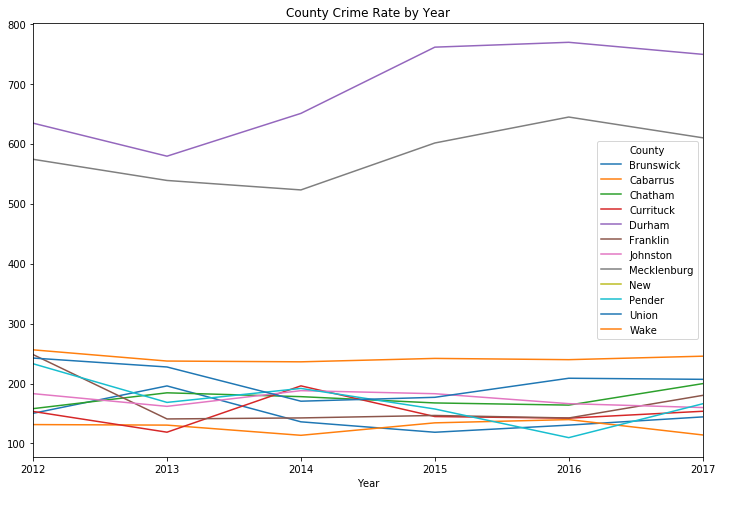

In [34]:
#Create Pivot and Plot
crime_xtab = pd.pivot_table(ci_yr, index='Year', columns = 'County', values = 'Violent_Crime_Rate')
#crime_xtab.head(15)
plt = crime_xtab.plot(figsize=(12,8), title = 'County Crime Rate by Year')
#plt.tight_layout()
#plt.show()

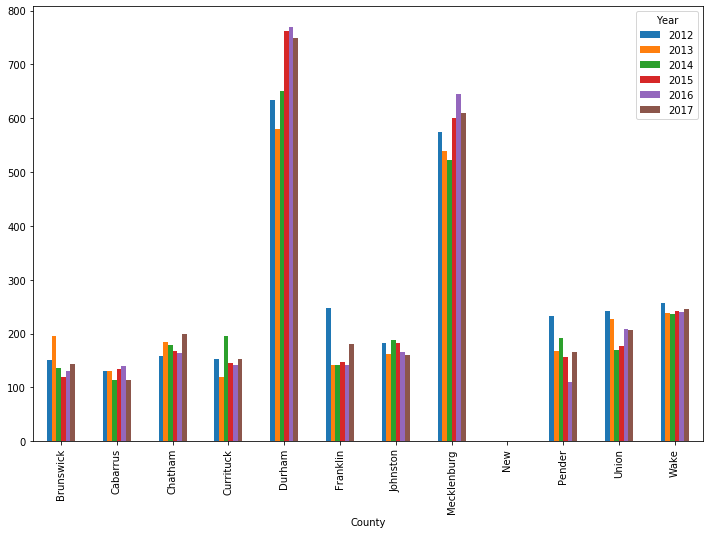

In [44]:
#Create Pivot and Plot
table2 = pd.pivot_table(ci_yr, index='County', columns = 'Year', values = 'Violent_Crime_Rate')
table2.head(15)
table2.plot.bar(figsize=(12,8))


In [49]:
table3 = pd.pivot_table(ci_yr, index='County', columns = 'Year', values = 'Violent_Crime_Rate')
table3.head(10)

Year,2012,2013,2014,2015,2016,2017
County,,,,,,
Brunswick,150.3,196.0,136.1,118.7,130.6,144.3
Cabarrus,131.5,130.6,113.6,134.4,139.8,114.2
Chatham,158.1,184.5,178.1,167.6,164.0,199.8
Currituck,153.4,118.8,196.1,144.9,142.2,153.7
Durham,634.4,579.3,650.7,761.2,769.3,749.2
Franklin,248.3,140.9,142.6,146.7,142.5,180.2
Johnston,183.1,161.9,188.1,183.0,166.4,159.9
Mecklenburg,574.1,538.8,523.0,601.3,644.6,610.0
New,inf,inf,inf,inf,inf,inf


In [50]:
years = table3.keys()
years

Index(['2012', '2013', '2014', '2015', '2016', '2017'], dtype='object', name='Year')